Plots win rate vs. varying adversary/victim visits.

In [1]:
import re
from typing import Tuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("2-col")]
)


def force_minor_ticks(ax: matplotlib.axes.Axes) -> None:
    """Force minor ticks to show on a plot."""
    # https://stackoverflow.com/a/73094650/1337463
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))

### A-MCTS-R and A-MCTS-S++ vs. varying victim visits

In [2]:
def get_adv_win_grouped_by_victim_visits(
    df: pd.DataFrame,
    df_query: str,
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by victim visits.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("victim_visits")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi


def plot_victim_visit_sweep(
    df: pd.DataFrame,
    victim_label: str,
    amcts_sxx_name_substring: str = "AMCTS-S++",
    max_amcts_r_victim_visits: int = 128,
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot performance of A-MCTS-{R,S++} vs. varying victim visits.

    Args:
        df: Dataframe of games.
        victim_label: The label to give the victim on the plot.
        amcts_sxx_name_substring: An identifying substring that appears in the
            A-MCTS-S++ adversary's name but not the AMCTS-R adversary's name.
        max_amcts_r_victim_visits: The number of victim visits at which to cut off
            the plotted line for A-MCTS-R.
    """
    utils.parse_for_match(df)
    fig, ax = plt.subplots(1, 1)

    amcts_sxx_name_substring = re.escape(amcts_sxx_name_substring)

    m, l, h = get_adv_win_grouped_by_victim_visits(
        df,
        f"~adv_name.str.contains('{amcts_sxx_name_substring}') & victim_visits <= {max_amcts_r_victim_visits}",
    )
    m.plot(label="A-MCTS-R", zorder=10, linestyle="--")
    ax.fill_between(m.index, l, h, alpha=0.3)

    m, l, h = get_adv_win_grouped_by_victim_visits(
        df, f"adv_name.str.contains('{amcts_sxx_name_substring}')"
    )
    m.plot(label="A-MCTS-S++")
    ax.fill_between(m.index, l, h, alpha=0.3)

    plt.ylim(-5, 105)
    plt.xscale("log")
    plt.ylabel(f"Adv. win \\% vs. {victim_label}")
    plt.xlabel("Victim visits")
    plt.legend()
    force_minor_ticks(ax)

    return fig, ax

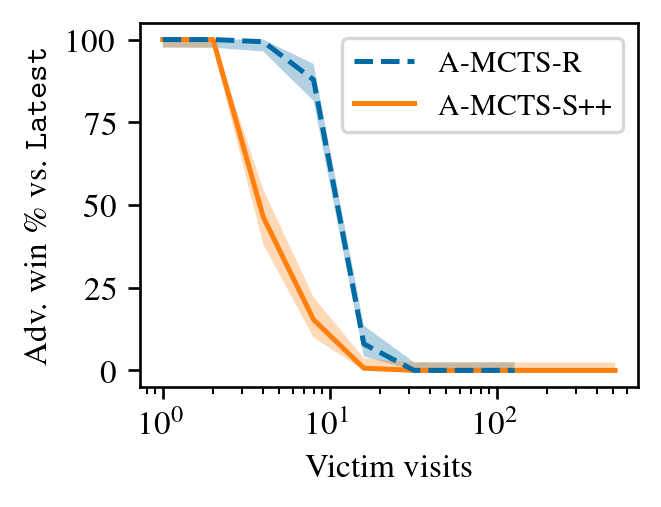

In [3]:
# adversary s34mil from unhardened training run
df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-unhardened-paper-eval-221130/ttseng-victim-v-sweep-amcts-r-20221130-210359/sgfs",
        "/nas/ucb/k8/go-attack/match/ttseng-unhardened-paper-eval-221130/ttseng-victim-v-sweep-amcts-sxx-20221130-210350/sgfs",
    ]
)

fig, ax = plot_victim_visit_sweep(df, "$\\texttt{Latest}$")
# Give the legend a smaller font to avoid covering up plot lines.
ax.legend(prop={"size": 9})
fig.savefig("adv-vs-cp505-vary-visits.pgf", backend="pgf")

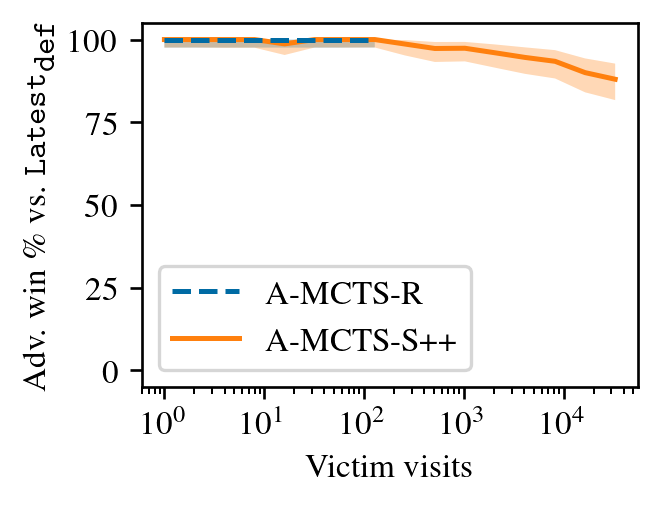

In [4]:
# adversary 497mil from hardened training run
df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-victim-v-sweep-amcts-r-20230118-001712",
        "/nas/ucb/k8/go-attack/match/ttseng-victim-v-sweep-amcts-sxx-20230117-235656",
    ]
)
fig, _ = plot_victim_visit_sweep(df, "$\\texttt{Latest}_\\texttt{def}$")
fig.savefig("adv-545mil-vs-cp505h-vary-visits.pgf", backend="pgf")

### A-MCTS-S, varying adv. visits

In [5]:
def plot_adv_visit_sweep(
    adv_visit_sweep_df: pd.DataFrame,
    victim_visit_sweep_df: pd.DataFrame,
    victim_label: str,
    amcts_sxx_name_substring: str = "AMCTS-S++",
    alpha: float = 0.05,
) -> matplotlib.figure.Figure:
    """Plot performance of A-MCTS-S with varying adversary visits.

    Args:
        adv_visit_sweep_df: Data for adversary visit sweep experiment.
        victim_visit_sweep_df: Data for victim visit sweep experiment.
        victim_label: The label to give the victim on the plot.
        amcts_sxx_name_substring: An identifying substring that appears in the
            A-MCTS-S++ adversary's name but not the AMCTS-R adversary's name.
    """
    utils.parse_for_match(adv_visit_sweep_df)
    utils.parse_for_match(victim_visit_sweep_df)

    all_victim_visits = df.victim_visits.unique()
    assert len(all_victim_visits) == 1
    victim_visits = all_victim_visits[0]

    visit_query = f"victim_visits == {victim_visits}"
    gb = adv_visit_sweep_df.query(visit_query).groupby("adv_visits")
    adv_sweep_win_rates = gb.adv_win.mean()
    adv_sweep_lo, adv_sweep_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )
    print("A-MCTS-S win rate:\n", adv_sweep_win_rates)

    gb = victim_visit_sweep_df.query(visit_query).groupby("adv_name")
    victim_sweep_win_rates = gb.adv_win.mean()
    victim_sweep_lo, victim_sweep_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )
    print("A-MCTS-{S++,R} win rate:\n", victim_sweep_win_rates)
    assert victim_sweep_win_rates.shape[0] <= 2
    splusplus_point = None
    perfect_modeling_point = None
    for name in victim_sweep_win_rates.index:
        if amcts_sxx_name_substring in name:
            assert splusplus_point is None
            splusplus_point = victim_sweep_win_rates[name]
            splusplus_point_lo = victim_sweep_lo[name]
            splusplus_point_hi = victim_sweep_hi[name]
        else:
            assert perfect_modeling_point is None
            perfect_modeling_point = victim_sweep_win_rates[name]
            perfect_modeling_point_lo = victim_sweep_lo[name]
            perfect_modeling_point_hi = victim_sweep_hi[name]

    fig, ax = plt.subplots(1, 1)
    (100 * adv_sweep_win_rates).plot(label="A-MCTS-S")
    ax.fill_between(
        adv_sweep_win_rates.index,
        100 * adv_sweep_lo,
        100 * adv_sweep_hi,
        alpha=0.2,
    )

    if splusplus_point is not None:
        plt.plot(
            200,
            100 * splusplus_point,
            "s",
            label="A-MCTS-S++",
            markersize=6,
            color="tab:red",
        )
        plt.errorbar(
            200,
            100 * splusplus_point,
            yerr=[
                [100 * (splusplus_point - splusplus_point_lo)],
                [100 * (splusplus_point_hi - splusplus_point)],
            ],
            color="tab:red",
            capsize=3,
            alpha=0.6,
        )

    if perfect_modeling_point is not None:
        plt.plot(
            200,
            100 * perfect_modeling_point,
            "o",
            label="A-MCTS-R",
            markersize=6,
            color="tab:green",
        )
        plt.errorbar(
            200,
            100 * perfect_modeling_point,
            yerr=[
                [100 * (perfect_modeling_point - perfect_modeling_point_lo)],
                [100 * (perfect_modeling_point_hi - perfect_modeling_point)],
            ],
            color="tab:green",
            capsize=3,
            alpha=0.6,
        )

    plt.ylim(-5, 105)
    plt.xscale("log")
    force_minor_ticks(ax)

    plt.xlabel(f"Adversary visits")
    plt.ylabel(f"Adv. win \\% vs. {victim_label}")
    plt.legend()
    return fig, ax

A-MCTS-S win rate:
 adv_visits
1       0.120000
2       0.073333
4       0.073333
8       0.113333
16      0.173333
32      0.206667
64      0.193333
128     0.133333
256     0.120000
512     0.133333
1024    0.073333
2048    0.073333
4096    0.073333
8192    0.006667
Name: adv_win, dtype: float64
A-MCTS-{S++,R} win rate:
 adv_name
adv-s34090496-v200-AMCTS-R      0.878378
adv-s34090496-v200-AMCTS-S++    0.153333
Name: adv_win, dtype: float64


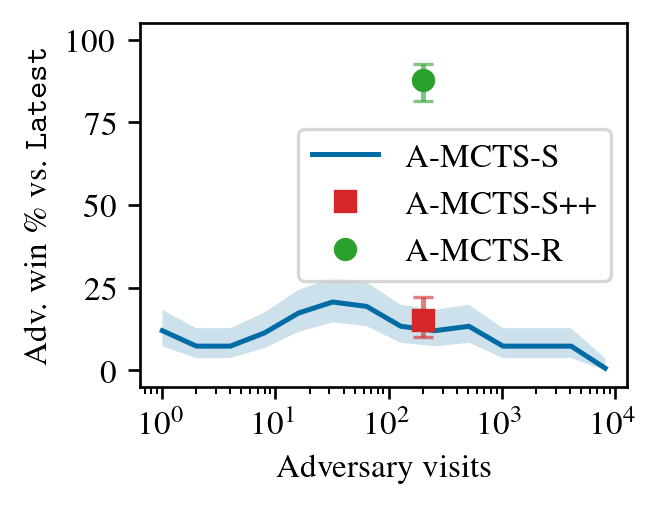

In [6]:
df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-unhardened-paper-eval-221130/ttseng-adv-v-sweep-v8-20221204-232530"
    ]
)
df2 = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-unhardened-paper-eval-221130/ttseng-victim-v-sweep-amcts-r-20221130-210359/sgfs",
        "/nas/ucb/k8/go-attack/match/ttseng-unhardened-paper-eval-221130/ttseng-victim-v-sweep-amcts-sxx-20221130-210350/sgfs",
    ]
)
fig, _ = plot_adv_visit_sweep(df, df2, "$\\texttt{Latest}$")
fig.savefig("adv-vs-cp505-vary-visits2.pgf", backend="pgf")

['adv-s545065216-v600-AMCTS-R' 'adv-s545065216-v600-AMCTS-S++']
A-MCTS-S win rate:
 adv_visits
1        0.460526
2        0.407895
4        0.553333
8        0.786667
16       0.760000
32       0.849315
64       0.932432
128      0.967105
256      0.926667
512      0.967105
1024     0.947368
2048     0.933333
4096     0.904110
8192     0.900000
16384    0.806667
32768    0.760000
Name: adv_win, dtype: float64
A-MCTS-{S++,R} win rate:
 adv_name
adv-s545065216-v600-AMCTS-S++    0.945946
Name: adv_win, dtype: float64


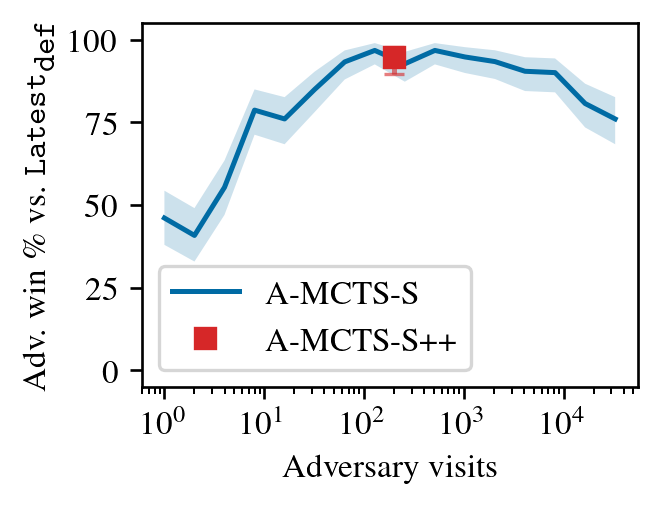

In [7]:
df = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-adv-v-sweep-20230117-235707"]
)
df2 = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-victim-v-sweep-amcts-r-20230118-001712",
        "/nas/ucb/k8/go-attack/match/ttseng-victim-v-sweep-amcts-sxx-20230117-235656",
    ]
)
print(df2.adv_name.unique())
fig, _ = plot_adv_visit_sweep(
    df,
    df2,
    "$\\texttt{Latest}_\\texttt{def}$",
)
fig.savefig("adv-545mil-vs-cp505h-v4096-vary-adv-visits.pgf", backend="pgf")